* ##### GenAI Impact Navigator: Uncovering Productivity Dynamics in Enterprise AI Adoption
* ##### Name: Barath Anandaraman
* ##### Course: DSC680-T301
* ##### Weeks 5 - 7: Milestone 2
* ##### Date: 07/10/2025

---

#### Load necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

##### Load the dataset

In [2]:
file = "Enterprise_GenAI_Adoption_Impact.csv"
adoption_df = pd.read_csv(file)

##### Display basic information of the dataset

In [3]:
adoption_df.info(), adoption_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Company Name                  100000 non-null  object 
 1   Industry                      100000 non-null  object 
 2   Country                       100000 non-null  object 
 3   GenAI Tool                    100000 non-null  object 
 4   Adoption Year                 100000 non-null  int64  
 5   Number of Employees Impacted  100000 non-null  int64  
 6   New Roles Created             100000 non-null  int64  
 7   Training Hours Provided       100000 non-null  int64  
 8   Productivity Change (%)       100000 non-null  float64
 9   Employee Sentiment            100000 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 7.6+ MB


(None,
                               Company Name     Industry       Country  \
 0                      Davis LLC Pvt. Ltd.   Healthcare           USA   
 1  Roberts, Holland and Bradshaw Pvt. Ltd.      Telecom  South Africa   
 2                      Roman Inc Pvt. Ltd.  Advertising         India   
 
   GenAI Tool  Adoption Year  Number of Employees Impacted  New Roles Created  \
 0    Mixtral           2022                          5277                  8   
 1     Claude           2023                         18762                 17   
 2     Gemini           2023                         11307                 17   
 
    Training Hours Provided  Productivity Change (%)  \
 0                      657                     25.2   
 1                    23021                     27.5   
 2                     4680                     11.5   
 
                                   Employee Sentiment  
 0  Productivity increased, but there's anxiety ab...  
 1  We now finish tasks faster,

---

#### Understanding of data
- Dataset has 100,000 rows and 10 columns
- No missing values found in any column
- 5 columns of type object 
- 4 columns of type int64 and 1 of float64

#### Data Preprocessing
Identified categorical columns:
- Company Name
- Industry
- Country
- GenAI Tool
- Employee Sentiment (may need further preprocessing/ sentiment categorization)

---

#### Outlier detection

In [4]:
# Identify numeric columns for outlier detection
numeric_cols = adoption_df.select_dtypes(include=[np.number]).columns

In [5]:
# Function to detect outliers using IQR
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers.shape[0], lower, upper

In [6]:
# Analyze outliers for wach numeric column
outlier_summary = []
for col in numeric_cols:
    count, lower, upper = detect_outliers(adoption_df, col)
    outlier_summary.append({
        "Column": col,
        "Outliers": count,
        "Lower Bound": lower,
        "Upper Bound": upper
    })
outlier_df = pd.DataFrame(outlier_summary)

In [7]:
outlier_df

,Column,Outliers,Lower Bound,Upper Bound
0,Adoption Year,0,2019.000,2027.000
1,Number of Employees Impacted,0,-9932.125,30048.875
2,New Roles Created,0,-14.500,45.500
3,Training Hours Provided,0,-11692.000,37142.000
4,Productivity Change (%),0,-14.550,51.450


---

#### Summary of Outlier detection
- All values fall within expected statistical boundaries
- Most likely the data has been pre-cleaned or synthetically generation with controlled distributions

---

#### Feature Engineering

##### Feature: Age of Adoption

In [8]:
current_year = datetime.now().year
adoption_df['Age of Adoption'] = current_year - adoption_df['Adoption Year']

##### Normalize components for adoption intensity

In [9]:
scaler = MinMaxScaler()
adoption_df[['Impact_Score','Training_Score']] = scaler.fit_transform(
    adoption_df[['Number of Employees Impacted', 'Training Hours Provided']]
)

##### Feature: Adoption Intensity

In [10]:
adoption_df['Adoption Intensity'] = 0.6 * adoption_df['Impact_Score'] + 0.4 * adoption_df['Training_Score']

##### Feature: Productivity Efficiency

In [11]:
adoption_df['Productivity Efficiency'] = adoption_df['Productivity Change (%)'] / (adoption_df['Training Hours Provided'] + 1)

##### Feature: Role Creation Rate

In [12]:
adoption_df['Role Creation Rate'] = adoption_df['New Roles Created'] / (adoption_df['Number of Employees Impacted'] + 1)

##### Basic Function for rule based Sentiment categorization

In [13]:
def categorize_sentiment(text):
    text = text.lower()
    if 'anxiety' in text or 'concern' in text or 'fear' in text:
        return 'Negative'
    elif 'good' in text or 'happy' in text or 'satisfied' in text:
        return 'Positive'
    else:
        return 'Neutral'

##### Feature: Sentiment category

In [14]:
adoption_df['Sentiment Category'] = adoption_df['Employee Sentiment'].apply(categorize_sentiment)

##### Display new features

In [15]:
adoption_df[['Age of Adoption', 'Adoption Intensity', 'Productivity Efficiency', 'Sentiment Category']].head(3)

,Age of Adoption,Adoption Intensity,Productivity Efficiency,Sentiment Category
0,3,0.158654,0.038298,Negative
1,2,0.930363,0.001195,Neutral
2,2,0.406144,0.002457,Negative


---

#### Encoding categorical columns

In [16]:
label_encoders = {}
categorical_cols = ['Industry', 'Country', 'GenAI Tool', 'Sentiment Category']

In [17]:
for col in categorical_cols:
    le = LabelEncoder()
    adoption_df[col + '_Encoded'] = le.fit_transform(adoption_df[col])
    label_encoders[col] = le

---

##### Visualize Tool popularity

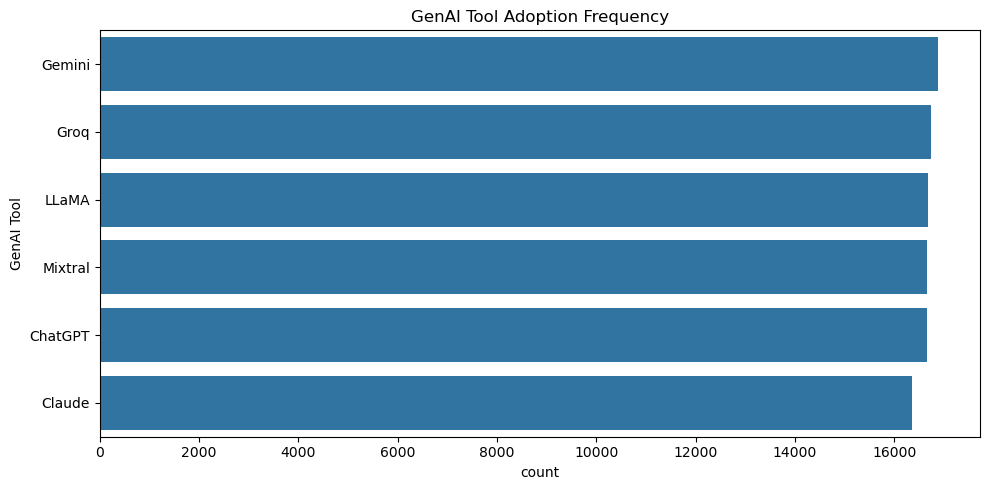

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(data = adoption_df, y='GenAI Tool', order=adoption_df['GenAI Tool'].value_counts().index)
plt.title('GenAI Tool Adoption Frequency')
plt.ylabel('GenAI Tool')
plt.tight_layout()
plt.show()

##### Average Productivity per tool

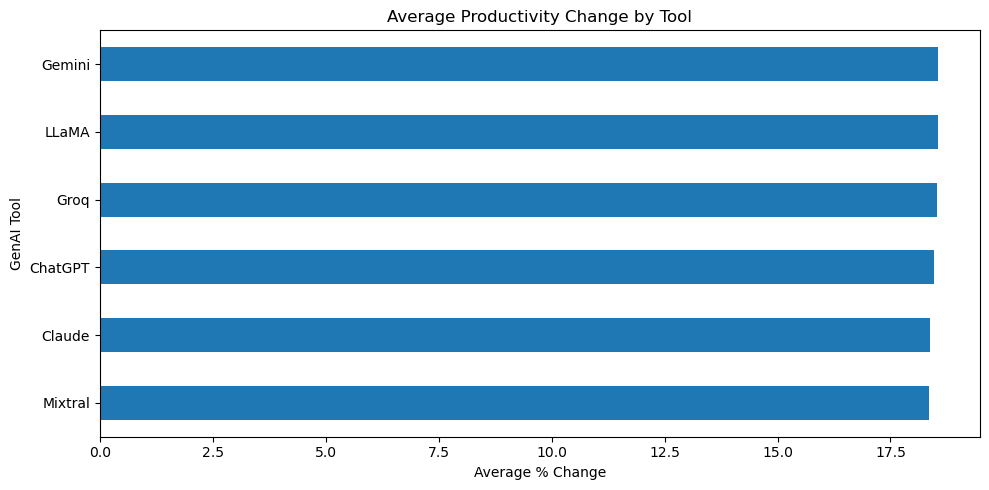

In [38]:
adoption_df.groupby('GenAI Tool')['Productivity Change (%)'].mean().sort_values().plot(
    kind='barh', figsize=(10,5), title='Average Productivity Change by Tool')
plt.xlabel('Average % Change')
plt.tight_layout()
plt.show()

##### Productivity Distribution by Tool

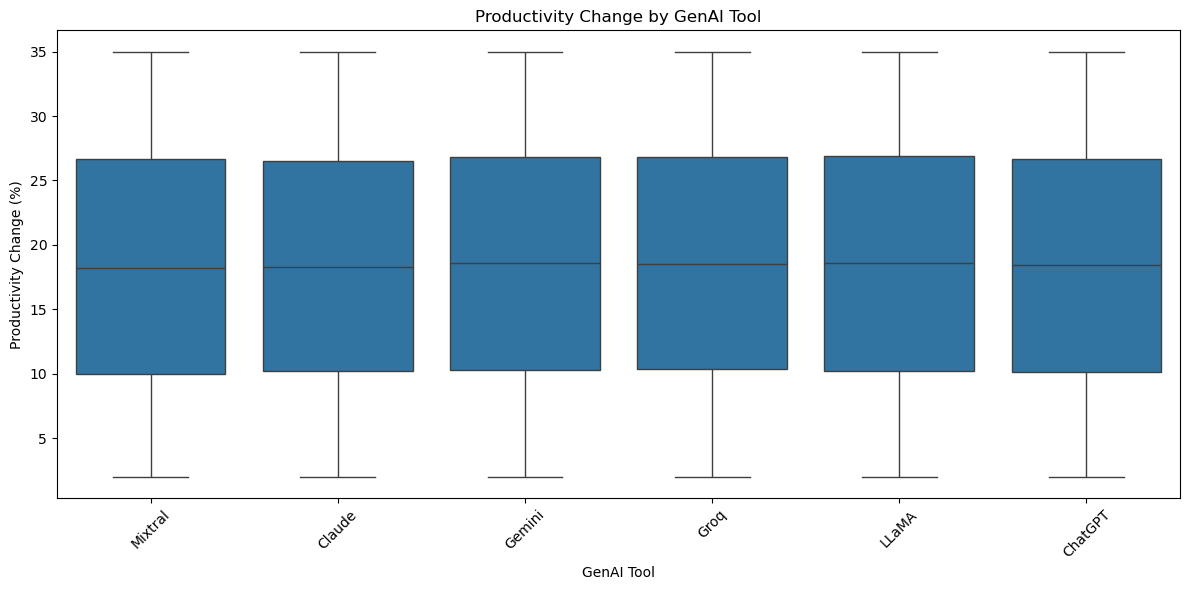

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(data=adoption_df, x='GenAI Tool', y='Productivity Change (%)')
plt.xticks(rotation=45)
plt.title('Productivity Change by GenAI Tool')
plt.tight_layout()
plt.show()

##### Training hours vs Tool

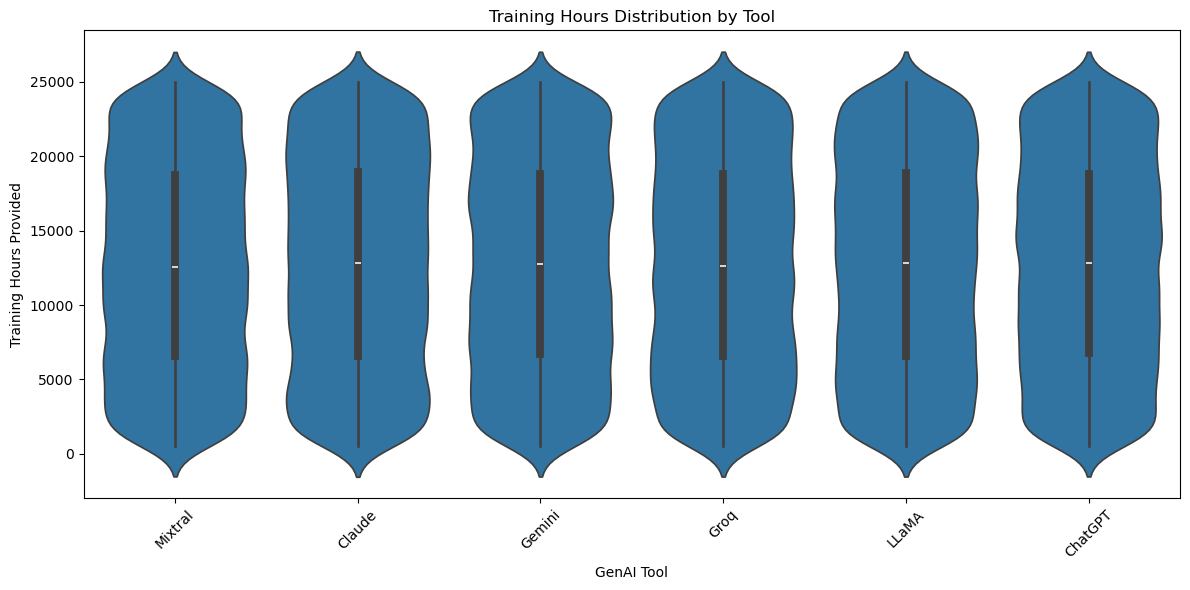

In [21]:
plt.figure(figsize=(12,6))
sns.violinplot(data=adoption_df, x='GenAI Tool', y='Training Hours Provided')
plt.xticks(rotation=45)
plt.title('Training Hours Distribution by Tool')
plt.tight_layout()
plt.show()

##### New Roles created by Tool

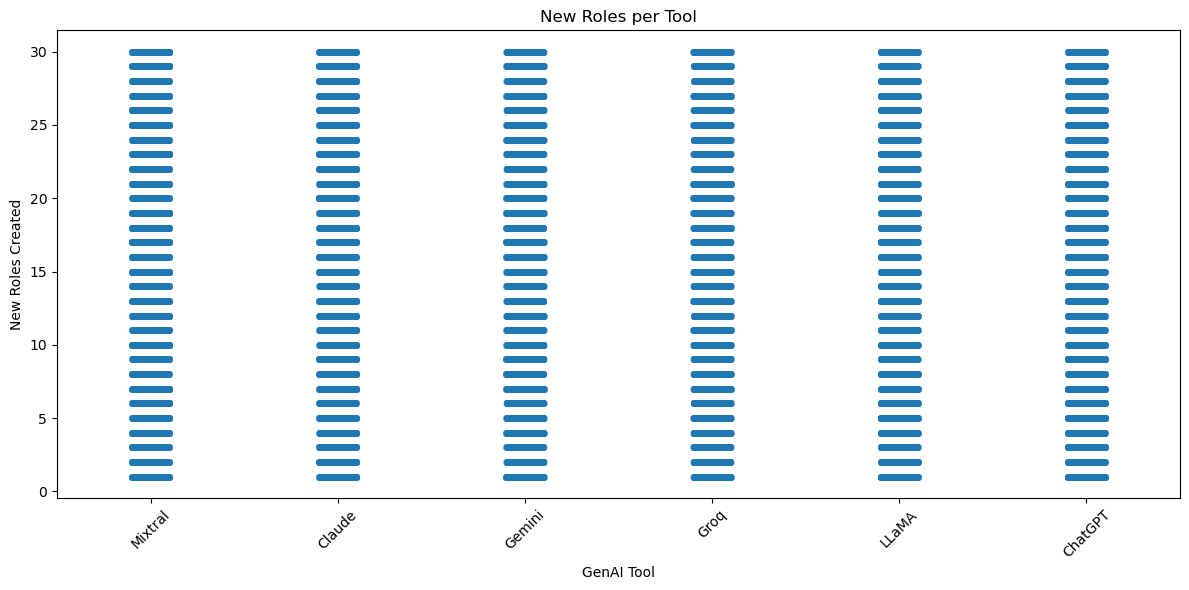

In [42]:
plt.figure(figsize=(12,6))
sns.stripplot(data=adoption_df, x='GenAI Tool', y='New Roles Created', jitter=True, alpha=0.3)
plt.xticks(rotation=45)
plt.title('New Roles per Tool')
plt.tight_layout()
plt.show()

##### Adoption Intensity Vs Productivity by Tool

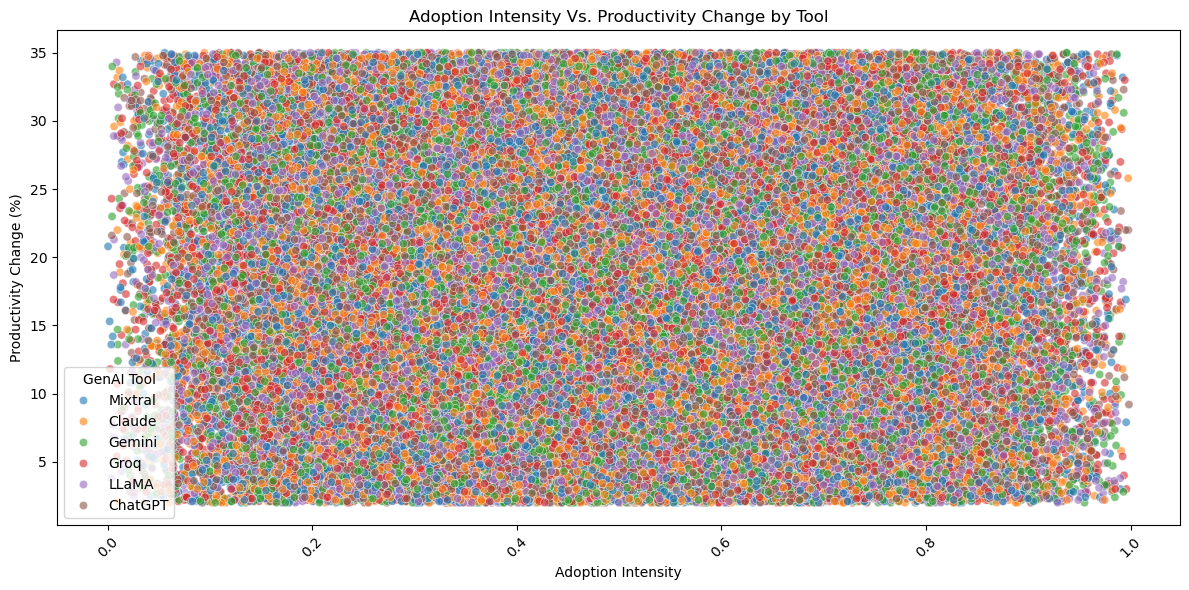

In [40]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=adoption_df, x='Adoption Intensity', y='Productivity Change (%)', hue='GenAI Tool', alpha=0.6)
plt.xticks(rotation=45)
plt.title('Adoption Intensity Vs. Productivity Change by Tool')
plt.tight_layout()
plt.show()

##### Heatmap: Tool vs Industry vs Avg Productivity

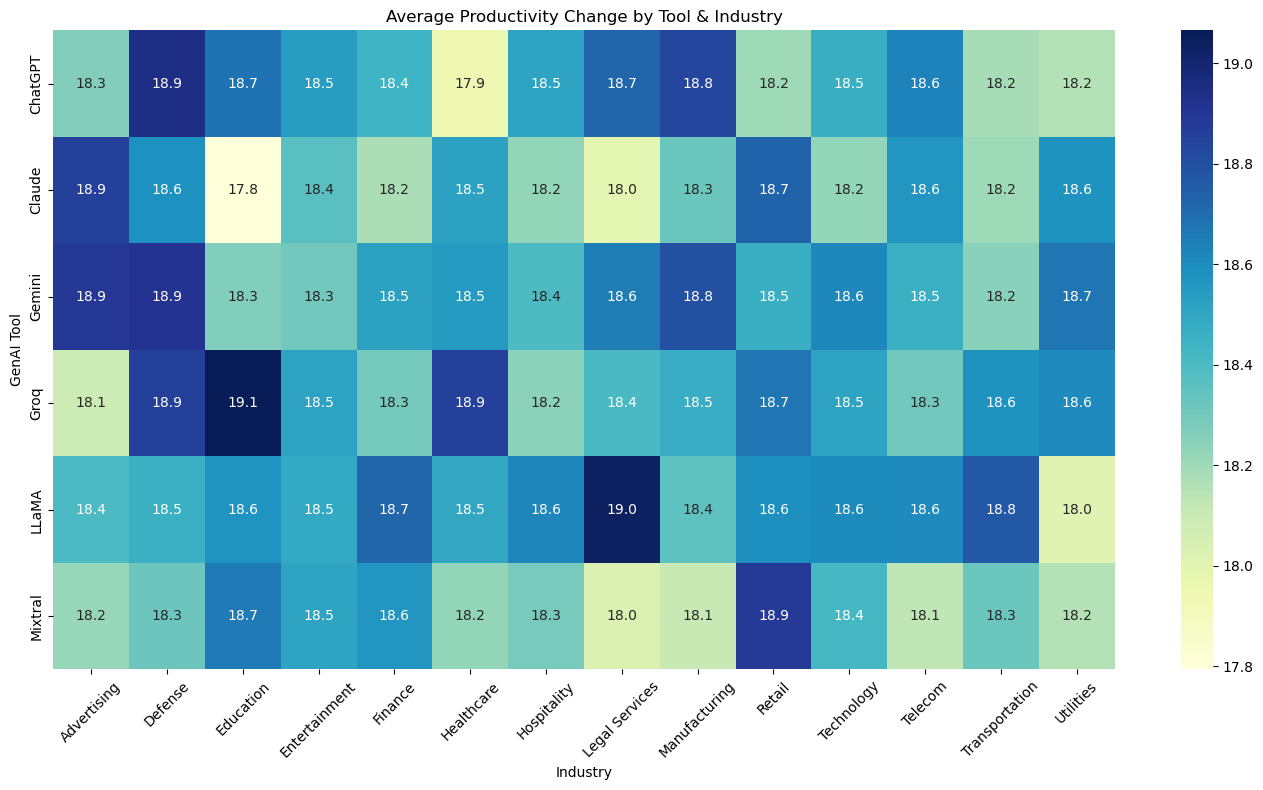

In [24]:
heatmap_data = adoption_df.pivot_table(index='GenAI Tool', columns='Industry', values='Productivity Change (%)',
                                      aggfunc='mean')
plt.figure(figsize=(14,8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.1f')
plt.xticks(rotation=45)
plt.title('Average Productivity Change by Tool & Industry')
plt.tight_layout()
plt.show()

##### Role Creation Rate vs Adoption Intensity

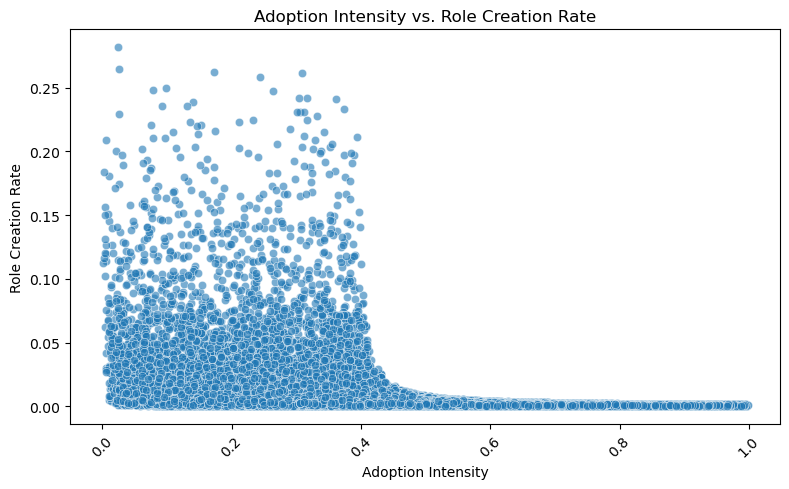

In [25]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=adoption_df, x='Adoption Intensity', y='Role Creation Rate', alpha=0.6)
plt.xticks(rotation=45)
plt.title('Adoption Intensity vs. Role Creation Rate')
plt.tight_layout()
plt.show()

##### Sentiment Category Distribution

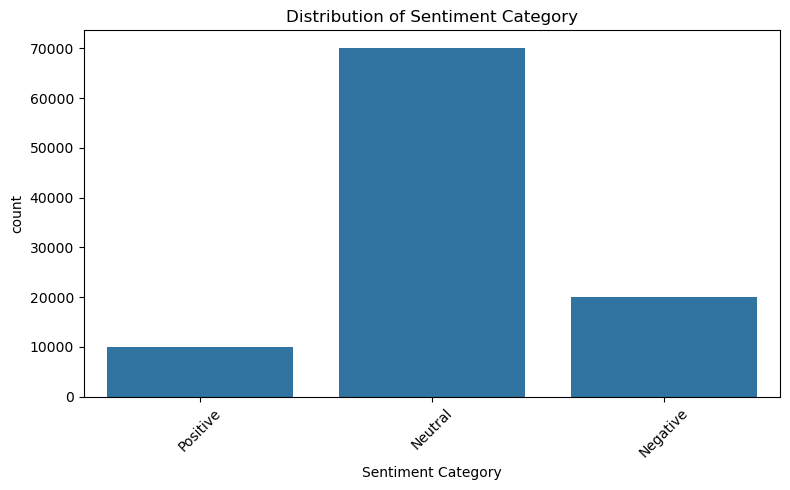

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(data=adoption_df, x='Sentiment Category', order=['Positive', 'Neutral', 'Negative'])
plt.xticks(rotation=45)
plt.title('Distribution of Sentiment Category')
plt.tight_layout()
plt.show()

---

#### Correlation Matrix

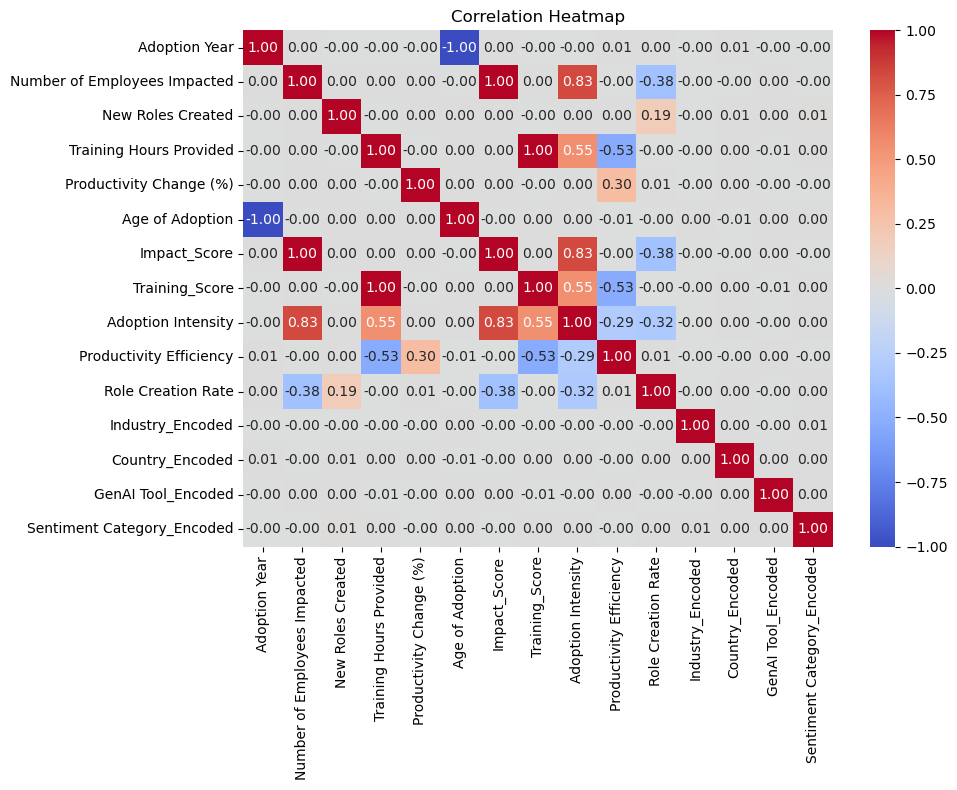

In [27]:
plt.figure(figsize=(10,8))
corr_matrix = adoption_df.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

---

#### Model Building

In [28]:
# Select features and target
features = [
    'Adoption Intensity',
    'Age of Adoption',
    'Productivity Efficiency',
    'Role Creation Rate',
    'Number of Employees Impacted',
    'Training Hours Provided',
    'New Roles Created'
]
target = 'Productivity Change (%)'

In [29]:
X = adoption_df[features]
y = adoption_df[target]
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#### Fit Linear regression model

In [30]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

#### Prediction

In [31]:
y_pred = lr_model.predict(X_test)

#### Model Evaluation

In [32]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': lr_model.coef_})
mse, r2, coefficients.sort_values(by='Coefficient', ascending=False)

(79.95673086852527,
 0.11876352101728604,
                         Feature   Coefficient
 2       Productivity Efficiency  7.765915e+02
 3            Role Creation Rate  3.883263e+00
 1               Age of Adoption  6.324522e-02
 6             New Roles Created  1.051620e-03
 5       Training Hours Provided  3.038977e-04
 4  Number of Employees Impacted  9.017098e-06
 0            Adoption Intensity  5.216887e-09)

---

#### Regularized Regression

#### Ridge Regression

In [33]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_coeffs = pd.DataFrame({'Feature': features, 'Ridge Coefficient': ridge.coef_})
ridge_mse, ridge_r2, ridge_coeffs.sort_values(by='Ridge Coefficient', ascending=False)

(81.33223254870403,
 0.10360354331048494,
                         Feature  Ridge Coefficient
 2       Productivity Efficiency       4.696464e+02
 3            Role Creation Rate       4.128788e+00
 1               Age of Adoption       5.838277e-02
 6             New Roles Created       1.617350e-03
 5       Training Hours Provided       1.851192e-04
 4  Number of Employees Impacted       9.075048e-06
 0            Adoption Intensity       3.274110e-09)

#### Lasso Regression

In [34]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_coeffs = pd.DataFrame({'Feature': features, 'Lasso Coefficient': ridge.coef_})
lasso_mse, lasso_r2, lasso_coeffs.sort_values(by='Lasso Coefficient', ascending=False)

(90.74124507216155,
 -9.710798940343324e-05,
                         Feature  Lasso Coefficient
 2       Productivity Efficiency       4.696464e+02
 3            Role Creation Rate       4.128788e+00
 1               Age of Adoption       5.838277e-02
 6             New Roles Created       1.617350e-03
 5       Training Hours Provided       1.851192e-04
 4  Number of Employees Impacted       9.075048e-06
 0            Adoption Intensity       3.274110e-09)

---

#### Tree based Regression

#### Random Forest Regression

In [35]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mse, rf_r2

(0.00640033319999997, 0.9999294592583736)

#### Feature importance Plot

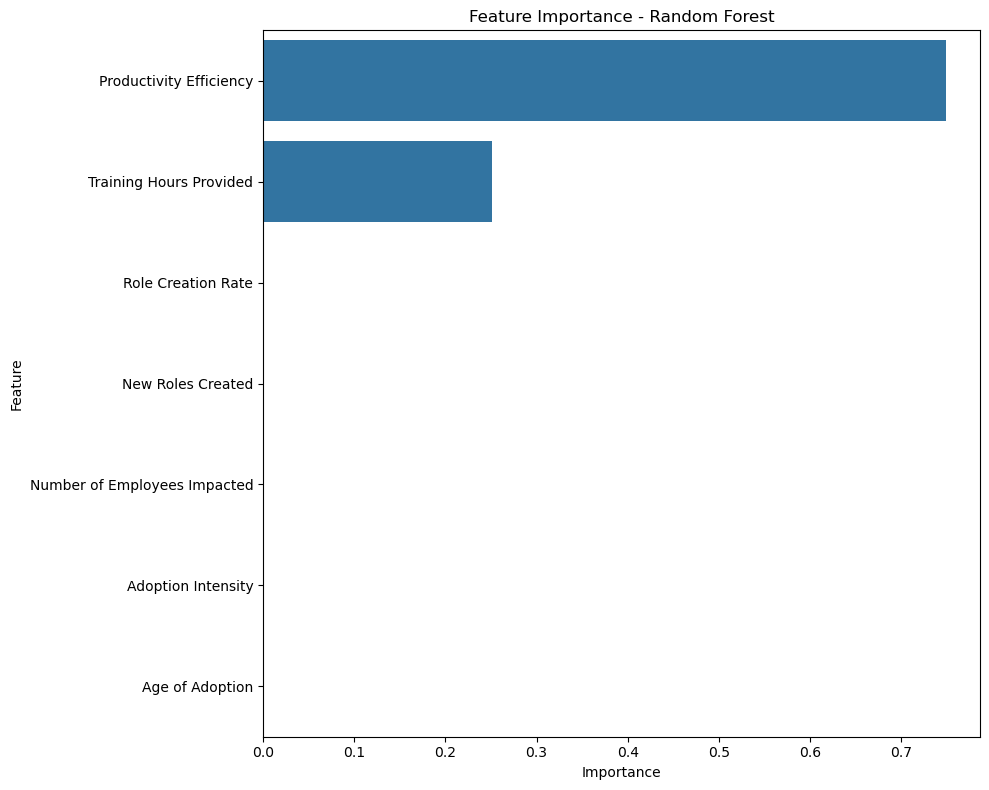

In [36]:
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()